<a href="https://colab.research.google.com/github/daarisameen/Ml-DL-projects/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# End to End ML IITM: https://colab.research.google.com/drive/1leWpYtJrBhLf426Q2Emj1o3nNylPaJ0O?usp=sharing
# heart - https://media.licdn.com/dms/document/media/D4D1FAQFRlrkzgq8vMg/feedshare-document-pdf-analyzed/0/1696704666094?e=1698883200&v=beta&t=u-Ut36lewfXkDpX04b6MTvxFsTzVb4qkLu5AxKN4GcM
# taxi - https://media.licdn.com/dms/document/media/C4D1FAQEzUwZsEB0JLA/feedshare-document-pdf-analyzed/0/1679913090300?e=1698883200&v=beta&t=cuW5AsFBS9cZ-Va3hKcNItzeuI9Xq1xx5tx8ROQKkWY

# https://medium.com/@sthanikamsanthosh1994/context-aware-sentence-matching-using-ml-techniques-f93a28c4d1a1
# https://datascience.stackexchange.com/questions/75299/how-to-figure-out-if-two-sentences-have-the-same-meaning-with-ai
# https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb
# https://colab.research.google.com/github/mepky/movie-recommendation-system/blob/master/Movie_recommendation_engine.ipynb#scrollTo=H1Ta9vMPcsGW

# https://www.imdb.com/search/title/?num_votes=0,&countries=kr&primary_language=ko&view=advanced&sort=user_rating,desc&title_type=tv_series&sort=num_votes,desc&sort=moviemeter,asc
# https://www.imdb.com/search/title/?num_votes=0,&countries=jp&primary_language=ja&view=advanced&sort=user_rating,desc&title_type=tv_series&sort=num_votes,desc&genres=animation&sort=moviemeter,asc
# https://www.imdb.com/search/title/?num_votes=0,&view=advanced&sort=user_rating,desc&title_type=game&sort=num_votes,desc&sort=moviemeter,asc

In [119]:
import string
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Perceptron, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.decomposition import PCA

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV

import pickle

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


## CREATE THE DATA SET

In [66]:
import requests
from bs4 import BeautifulSoup
import csv

# Define the URL to scrape
urlf = "https://www.imdb.com/search/title/?title_type=tv_series&num_votes=0,&genres=animation&countries=jp&primary_language=ja&start="
page_no = 1
urle = "&ref_=adv_nxt"

# Create a CSV file to store the data
csv_file = open("anime_data.csv", mode="w", newline='', encoding="utf-8")
csv_writer = csv.writer(csv_file)

# Write the header row to the CSV file
csv_writer.writerow(["Rank", "Anime Name", "Release Year", "Genre", "Rating", "Votes", "Description", "Cast"])

for i in range(1, 2900, 50):
    url = urlf + str(i) + urle

    # Send an HTTP GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content of the page using BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the elements containing anime data
        anime_items = soup.find_all('div', class_='lister-item-content')

        # Extract and write the data to the CSV file
        for idx, item in enumerate(anime_items):
            # Calculate the rank as the index plus 1
            rank = idx + 1

            # Extract anime name
            anime_name = item.find('h3', class_='lister-item-header').a.text.strip()

            # Extract release year
            year_element = item.find('span', class_='lister-item-year')
            release_year = year_element.text.strip() if year_element else "N/A"

            # Extract genre as a list and remove elements with the value "Animation"
            genre_element = item.find('span', class_='genre')
            genre_list = genre_element.text.split(",") if genre_element else ["N/A"]
            genre_list = [genre.strip() for genre in genre_list]
            genre_list = [genre for genre in genre_list if genre != "Animation"]

            if not genre_list:
              genre_list = ["not decided"]

            # Extract rating
            rating_element = item.find('div', class_='inline-block ratings-imdb-rating')
            rating = rating_element.strong.text if rating_element else "N/A"

            # Extract number of votes
            votes_element = item.find('span', attrs={'name': 'nv'})
            votes = votes_element['data-value'] if votes_element else "N/A"

            # Extract description from the second 'text-muted' class
            description_element = item.find_all('p', class_='text-muted')[1]
            description = description_element.text.strip() if description_element else "N/A"

            # Extract cast names from elements with an empty class attribute
            cast_element = item.find('p', class_='')
            cast = cast_element.text.strip() if cast_element else "N/A"
            cast = [name.strip().replace("Stars:", "").strip() for name in cast.split(',')]

            # Write the data to the CSV file
            csv_writer.writerow([rank, anime_name, release_year, ', '.join(genre_list), rating, votes, description, cast])
    else:
        print("Failed to retrieve the webpage. Status code:", response.status_code)

# Close the CSV file
csv_file.close()


1. Production name/Studio
2. Number of episodes and (released year)
3. Genre
4. (Plot)
5. Rating
6. Other famous anime produced by this studio
7. Please subscribe to this channel, my goal is to make my channel as No.1 anime channel in Youtube.

1. 10 Anime - If you loved "" (MUSIC).
2. center the name, put backgorund image, sub-pannels appear in anti clockwise direction.
3. Join my crew by subscribing - Monkey D Luffy.

I have a columns called
User_ratings, Movie_name, movie_description, genre, popularity_rank
write a ML code to train the model based on its description, user_rating, genre, and popularity_rank


just get the movie name from user and
and it is given that movie name will definitely present in the data set
Output should contain list of recommended movie_names

## LOAD THE DATA SET

In [146]:
data = pd.read_csv("anime_data.csv")
data[1:100]

,Rank,Anime Name,Release Year,Genre,Rating,Votes,Description,Cast
1,2,One Piece,(1999– ),"Action, Adventure",8.9,200307,Follows the adventures of Monkey D. Luffy and ...,"['Mayumi Tanaka', 'Akemi Okamura', 'Laurent Ve..."
2,3,Attack on Titan,(2013–2023),"Action, Adventure",9.0,446589,After his hometown is destroyed and his mother...,"['Josh Grelle', 'Bryce Papenbrook', 'Yûki Kaji..."
3,4,Demon Slayer: Kimetsu no Yaiba,(2019– ),"Action, Adventure",8.6,134966,A family is attacked by demons and only two me...,"['Natsuki Hanae', 'Zach Aguilar', 'Abby Trott'..."
4,5,Naruto: Shippuden,(2007–2017),"Action, Adventure",8.7,149325,"Naruto Uzumaki, is a loud, hyperactive, adoles...","['Alexandre Crepet', 'Junko Takeuchi', 'Maile ..."
5,6,Hunter x Hunter,(2011–2014),"Action, Adventure",9.0,122877,"Gon Freecss aspires to become a Hunter, an exc...","['Issei Futamata', 'Megumi Han', 'Cristina Val..."
...,...,...,...,...,...,...,...,...
95,46,Nana,(2006–2007),"Comedy, Drama",8.5,5115,"Two ostensibly opposite women, both named Nana...","['Romi Park', 'Kaori', 'Brian Drummond', 'Tosh..."
96,47,KILL la KILL,(2013–2014),"Action, Comedy",7.9,16130,A young girl arrives at a school of superhuman...,"['Ami Koshimizu', 'Aya Suzaki', 'Toshihiko Sek..."
97,48,Darling in the Franxx,(2018),"Action, Drama",7.3,12821,In a future world where humanity has been driv...,"['Yûto Uemura', 'Kana Ichinose', 'Nanami Yamas..."
98,49,Baki the Grappler,(2001–2007),"Action, Drama",7.5,2017,Baki Hanma competes in an underground fighting...,"['Bob Carter', 'Masami Kikuchi', 'Robert McCol..."


In [147]:
data.shape

(2900, 8)

In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          2900 non-null   int64  
 1   Anime Name    2900 non-null   object 
 2   Release Year  2900 non-null   object 
 3   Genre         2900 non-null   object 
 4   Rating        2900 non-null   float64
 5   Votes         2900 non-null   int64  
 6   Description   2900 non-null   object 
 7   Cast          2900 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 181.4+ KB


In [149]:
(data.isnull().sum())

Rank            0
Anime Name      0
Release Year    0
Genre           0
Rating          0
Votes           0
Description     0
Cast            0
dtype: int64

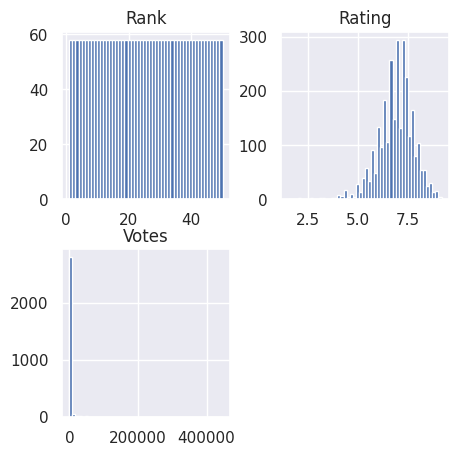

In [150]:
sns.set()
data.hist(bins=50,figsize=(5,5))
plt.show()

In [151]:
corr_matrix = data.copy().corr()
corr_matrix['Votes']

<ipython-input-151-3a72b1fd43b6>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.copy().corr()


Rank     -0.063405
Rating    0.214034
Votes     1.000000
Name: Votes, dtype: float64

<Axes: >

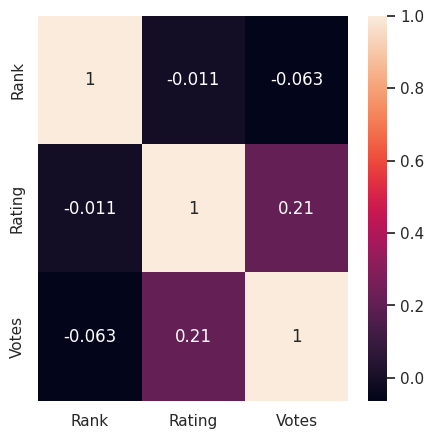

In [152]:
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix, annot=True)

In [153]:
temp = data.copy()
temp = temp.drop(['Rank'],axis=1)

temp.head()

,Anime Name,Release Year,Genre,Rating,Votes,Description,Cast
0,Jujutsu Kaisen,(2020– ),"Action, Adventure",8.6,88837,A boy swallows a cursed talisman - the finger ...,"['Junya Enoki', 'Yûichi Nakamura', 'Yuma Uchid..."
1,One Piece,(1999– ),"Action, Adventure",8.9,200307,Follows the adventures of Monkey D. Luffy and ...,"['Mayumi Tanaka', 'Akemi Okamura', 'Laurent Ve..."
2,Attack on Titan,(2013–2023),"Action, Adventure",9.0,446589,After his hometown is destroyed and his mother...,"['Josh Grelle', 'Bryce Papenbrook', 'Yûki Kaji..."
3,Demon Slayer: Kimetsu no Yaiba,(2019– ),"Action, Adventure",8.6,134966,A family is attacked by demons and only two me...,"['Natsuki Hanae', 'Zach Aguilar', 'Abby Trott'..."
4,Naruto: Shippuden,(2007–2017),"Action, Adventure",8.7,149325,"Naruto Uzumaki, is a loud, hyperactive, adoles...","['Alexandre Crepet', 'Junko Takeuchi', 'Maile ..."


In [154]:
temp.describe()

,Rating,Votes
count,2900.00000,2900.000000
mean,6.89269,2165.204138
std,0.90843,14849.332856
min,1.50000,5.000000
25%,6.40000,45.000000
50%,7.00000,143.000000
75%,7.50000,604.250000
max,9.20000,446589.000000


In [155]:
print(data['Votes'].value_counts())
print(" ")
print(data['Genre'].value_counts())
print(" ")
print(data['Rating'].value_counts())
print(" ")

12      29
11      27
19      26
8       25
30      25
        ..
1666     1
1990     1
1581     1
7203     1
355      1
Name: Votes, Length: 1136, dtype: int64
 
Action, Adventure       535
Comedy, Drama           247
not decided             219
Action, Comedy          206
Comedy                  140
                       ... 
Crime, Fantasy            1
Adventure, Biography      1
Music, Musical            1
Short, Romance            1
Biography, Comedy         1
Name: Genre, Length: 110, dtype: int64
 
7.0    166
7.2    161
6.8    147
6.6    137
7.3    132
      ... 
2.9      1
1.5      1
1.7      1
9.2      1
3.6      1
Name: Rating, Length: 67, dtype: int64
 


In [156]:
temp.shape

(2900, 7)

In [157]:
nltk.download('stopwords')
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters
    text = ''.join([char for char in text if char not in string.punctuation])

    # Remove common English stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)

    return text

temp['Description'] = temp['Description'].apply(preprocess_text)
temp['Description']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0       boy swallows cursed talisman finger demon beco...
1       follows adventures monkey luffy pirate crew or...
2       hometown destroyed mother killed young eren ja...
3       family attacked demons two members survive tan...
4       naruto uzumaki loud hyperactive adolescent nin...
                              ...                        
2895                                             add plot
2896    appearance convenience store clerk talk proper...
2897                                             add plot
2898                                             add plot
2899    story follows everyday life somera nonomoto us...
Name: Description, Length: 2900, dtype: object

In [ ]:
# temp = pd.get_dummies(temp, columns= ['Genre'])
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(temp.head(11))

In [161]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

def recommend_anime(input_anime, n=50):
    # Load the anime data from a CSV file
    df = temp

    # Check if the input anime is in the dataset
    if input_anime not in df['Anime Name'].values:
        return "Anime not found in the dataset"

    # Initialize the TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Fit and transform the descriptions to TF-IDF vectors
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Description'])

    # Get the index of the input anime
    input_index = df[df['Anime Name'] == input_anime].index[0]

    # Calculate cosine similarities between input anime and all other anime
    cosine_similarities = linear_kernel(tfidf_matrix[input_index], tfidf_matrix).flatten()

    # Get the indices of the top-n most similar anime
    similar_indices = cosine_similarities.argsort()[:-n-1:-1]

    # Extract and return the top-n anime names
    recommended_anime = df['Anime Name'].iloc[similar_indices[1:]]  # Exclude the input anime
    return recommended_anime

# Example usage

input_anime_name = "One Piece"  # Replace with the anime name you want recommendations for
recommended_anime = recommend_anime(input_anime_name, n=50)
print(recommended_anime)


162                                          Golden Kamuy
2753                                                Ozuma
1545                                    Space Pirate Mito
917                                           Space Cobra
1696                                   Cosmo Warrior Zero
740                                   Cobra the Animation
2197    Layton Mystery Tanteisha: Katori no Nazotoki File
925                                            Zoids Wild
390                                           Outlaw Star
2854                                            Acrobunch
2309                                         Gun Frontier
695                                               Stitch!
1916                                          Angel Links
1496                             Nanana's Buried Treasure
1055                                     Chi's Sweet Home
388                             Heidi: A Girl of the Alps
2290         Glass Fleet: La Legende du Vent de l'Univers
1670          

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Load your dataset (assuming you have a DataFrame)
# Replace 'data.csv' with your dataset file or source
df = pd.read_csv('anime_data.csv')

# Text-based features: movie_description
# User-based features: user_ratings (r) and popularity_rank (Unnamed: 0)
# Metadata-based features: genre
# Target variable: m_title (movie_name) for recommendation

# Content-Based Filtering
# TF-IDF Vectorization for movie descriptions
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['desp'])

# Combine user features
df['user_features'] = df['r'].astype(str) + ' ' + df['Unnamed: 0'].astype(str)

# Calculate cosine similarities between user features and descriptions
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to recommend movies based on a user-provided movie name
def recommend_movies_by_name(movie_name, n=10):
    # Get the index of the provided movie name
    movie_index = df[df['m_title'] == movie_name].index[0]

    # Calculate cosine similarities between user features and descriptions
    similar_m = list(enumerate(cosine_similarities[movie_index]))
    similar_m = sorted(similar_m, key=lambda x: x[1], reverse=True)
    similar_m = similar_m[1:n+1]

    # Extract movie indices
    movie_indices = [i[0] for i in similar_m]
    recommended_movies = df['m_title'].iloc[movie_indices]

    # Get additional information for recommended movies
    recommended_movie_info = df.loc[df['m_title'].isin(recommended_movies), ['m_title', 'r', 'desp', 'genre']]

    return recommended_movie_info

# Example: Recommend movies similar to a provided movie name
user_provided_movie = "Attack on Titan"
recommended_movies_info = recommend_movies_by_name(user_provided_movie)
recommended_movies_info


,m_title,r,desp,genre
318,Attack on Titan: Junior High,7.1,After his lunch is eaten by a Titan on the fir...,"Action, Adventure"
516,Girls Last Tour,7.7,Two girls wander a world destroyed by war.,"Adventure, Drama"
538,"Now and Then, Here and There",7.9,A Japanese boy named Shu tries to save a stran...,"Action, Adventure"
641,Monsuno,4.9,Monsuno hurtled through space eons before man ...,"Action, Adventure"
746,Mobile Suit Zeta Gundam,8.1,"Eight years after the One Year War, the Earth ...","Action, Drama"
1090,Muv-Luv Alternative,6.0,"In 1973, the invasion of an extra terrestrial ...","Action, Drama"
1390,Eureka Seven: Ao,6.7,"In a technologically advanced future, a young ...","Action, Drama"
1533,Pilot Candidate,5.7,The planet Zion is mankinds last hope for surv...,"Action, Drama"
2007,Monster Strike,4.8,"Ren Homura, a middle school student who moves ...",Action
2741,Sûpâ bikkuri man,7.0,After of the big war between angels and demons...,Fantasy


In [ ]:
write a function which accepts Anime Name as Input
and then it gives top 50 other anime names based on cosine similarity of their description with the description of input anime name.

Instagram

1000 to 10,000 followers -  $50/post

10,000 to 50,000 followers - $300/post

50,000 to 500,000 followers - $1500/post

500,000 to 1 million followers - $7000/post